In [1]:
import get_combine_data
import pandas as pd
import numpy as np
import altair as alt

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


just get data for one position. clean data frame with only the quantile measurements.

In [2]:
all_data = get_combine_data.get_data(drafted_only=True)

all_data.head()

on position P, can't do metric Vertical
on position K, can't do metric Vertical
on position P, can't do metric Bench
on position QB, can't do metric Bench
on position K, can't do metric Bench
on position P, can't do metric Broad Jump
on position K, can't do metric Broad Jump
on position P, can't do metric 3Cone
on position K, can't do metric 3Cone
on position P, can't do metric Shuttle
on position K, can't do metric Shuttle


,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,...,q_Broad Jump,q_3Cone,q_Shuttle,pos_d_40yd,pos_d_Vertical,pos_d_Bench,pos_d_Broad Jump,pos_d_3Cone,pos_d_Shuttle,composite_score
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.000000
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.000000
2,Darnell Alford,OT,Boston Col.,6-4,334.0,5.56,25.0,23.0,94.0,8.48,...,1.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.666667
4,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,...,78.0,47.0,78.0,1.0,1.0,NaN,5.0,1.0,4.0,2.400000
6,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.000000


In [3]:
quantile_cols = all_data.columns[all_data.columns.str.startswith("q_")]
#quantile_cols = quantile_cols.append("Player") # might want their names

quantile_cols = list(quantile_cols)

quantile_cols.sort()

In [4]:
running_backs = all_data[all_data.Pos == "RB"]

quantile_data = running_backs.loc[:, quantile_cols]

quantile_data.head()

,q_3Cone,q_40yd,q_Bench,q_Broad Jump,q_Shuttle,q_Vertical
1,NaN,62.0,NaN,NaN,NaN,NaN
41,NaN,92.0,28.0,NaN,NaN,NaN
48,86.0,65.0,18.0,92.0,70.0,88.0
77,NaN,51.0,NaN,NaN,NaN,NaN
81,35.0,50.0,7.0,42.0,37.0,20.0


ok, so I really like the look of this ridgeline plot: https://altair-viz.github.io/gallery/ridgeline_plot.html

but I'm getting impedence fitting my data into the format it wants. so I'll start simple.  taken from: https://altair-viz.github.io/gallery/density_facet.html


In [5]:
import altair as alt
from vega_datasets import data

source = data.iris()

alt.Chart(source).transform_fold(
    ['petalWidth',
     'petalLength',
     'sepalWidth',
     'sepalLength'],
    as_ = ['Measurement_type', 'value']
).transform_density(
    density='value',
    bandwidth=0.3,
    groupby=['Measurement_type'],
    extent= [0, 8]
).mark_area().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('Measurement_type:N')
).properties(width=300, height=50)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [6]:
quantile_data.head()

,q_3Cone,q_40yd,q_Bench,q_Broad Jump,q_Shuttle,q_Vertical
1,NaN,62.0,NaN,NaN,NaN,NaN
41,NaN,92.0,28.0,NaN,NaN,NaN
48,86.0,65.0,18.0,92.0,70.0,88.0
77,NaN,51.0,NaN,NaN,NaN,NaN
81,35.0,50.0,7.0,42.0,37.0,20.0


dropping na's is essential here. it doesn't automatically drop them, so they end up getting treated as 0 for the density plot. that still doesn't fix the wrong color problem.

In [7]:
source = quantile_data.dropna()#fillna(45.5)

scale = alt.Scale(scheme='lightgreyred')#, domainMid=50, bins=[0, 20, 40,60,80,100])#, domainMid=50)

#.transform_joinaggregate(
#    mean_value='mean(value)', groupby=['level_0']
#)

alt.Chart(source
).transform_fold(
    list(quantile_cols),
    as_ = ['Measurement_type', 'value']
).transform_density(
    density='value',
    groupby=['Measurement_type'],
    #counts=True,
    extent= [0, 100]
).transform_joinaggregate(
    groupby=['Measurement_type'],
    meas_mean='mean(value)',
    meas_count='count(value)',
    meas_sum='sum(value)'
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Fill('meas_mean:Q', scale=scale),
    alt.Row('Measurement_type:N')
).encode(
    tooltip=["meas_mean:Q", "meas_count:Q", "meas_sum:Q"]
).properties(width=300, height=50)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [8]:
source.dropna().describe()

,q_3Cone,q_40yd,q_Bench,q_Broad Jump,q_Shuttle,q_Vertical
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,66.018405,73.490798,42.803681,61.705521,64.061350,61.773006
std,19.875685,14.910171,23.581186,21.022308,20.837316,22.107286
min,17.000000,39.000000,0.000000,12.000000,15.000000,16.000000
25%,51.000000,63.000000,25.500000,46.000000,49.000000,45.500000
50%,69.000000,74.000000,38.000000,61.000000,67.000000,64.000000
75%,83.000000,85.000000,59.500000,78.000000,79.500000,78.000000
max,99.000000,98.000000,94.000000,99.000000,98.000000,99.000000


In [9]:
alt.Chart(source.dropna()
).transform_fold(
    list(quantile_cols),
    as_ = ['Measurement_type', 'value']
).mark_boxplot().encode(
    x='Measurement_type:O',
    y='value:Q'
)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

yeah, so the problem is that the means it's calculating are total nonsense, and I don't know where they're coming from.


the "joinaggregate" clause has to come after the "transform_density"

In [10]:
quantile_data.mean()

q_3Cone         65.133005
q_40yd          73.106322
q_Bench         41.742647
q_Broad Jump    62.975524
q_Shuttle       63.458537
q_Vertical      60.272109
dtype: float64

I think this might be a more friendly format for using with altair.

In [11]:
fool = quantile_data.reset_index(drop=True).unstack().reset_index(name='value').drop("level_1", axis=1).dropna()
#.drop_index().unstack().reset_index()

fool

,level_0,value
2,q_3Cone,86.0
4,q_3Cone,35.0
5,q_3Cone,72.0
7,q_3Cone,87.0
9,q_3Cone,81.0
...,...,...
2137,q_Vertical,47.0
2138,q_Vertical,66.0
2139,q_Vertical,71.0
2140,q_Vertical,75.0


well OK, this is ugly AF. the density plot is right, but the mean is still totally bogus. it's crazy. I tried some different switches on transform_density but nothing works.

SO I note that the ridgeline example doesn't use density estimation: https://altair-viz.github.io/gallery/ridgeline_plot.html

I'm not entirely clear on *how* the graph gets so smooth in the above, but clearly it works.

so the next step is to do the ridgeline and forget I ever saw `transform_density` though I think it's possible I could do a lookup of the mean from an external source, keyed on the 'level_0' (which I really should rename)

In [12]:
alt.Chart(fool).transform_density(
    density='value',
    groupby=['level_0'],
    as_=['metric', 'density']
).transform_joinaggregate(
    groupby=['level_0'],
    meas_mean='mean(metric)',
    meas_count='count(value)',
    meas_sum='sum(value)'
).mark_area().encode(
    alt.X('metric:Q'),
    alt.Y('density:Q'),
    alt.Row('level_0:N')
).encode(
    tooltip=["meas_mean:Q", "meas_count:Q", "meas_sum:Q"]
)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

I don't think the fill colors are actually right. q_40yd is 

so I'm struggling with how to get the fill color for each group...

looks like from here I need to put the mean for each row. but this is a different data format (EAV)

can I get the means in after the transform_fold call?

https://altair-viz.github.io/altair-viz-v4/user_guide/transform/joinaggregate.html

<Axes: >

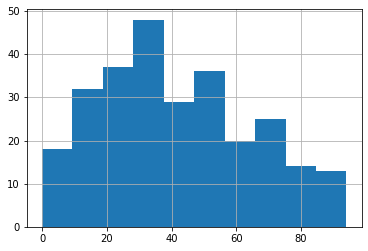

In [13]:
quantile_data.q_Bench.hist()

In [14]:
fool = fool.rename({"value": "myvalue"}, axis=1)

In [15]:
import altair as alt
from vega_datasets import data


step = 50
overlap = 0

alt.Chart(fool, height=step
).transform_joinaggregate(
    mean_value='mean(myvalue)', groupby=['level_0']
).transform_bin(
    ['bin_min', 'bin_max'], "myvalue", bin=alt.Bin(maxbins=100)
).transform_aggregate(
    value='count()', groupby=['level_0', 'mean_value', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['level_0', 'mean_value'], key='bin_min', value=0
).mark_area(

).encode(
    alt.X('bin_min:Q', scale=alt.Scale(domain=[0,100]), title='Percentile Compared to All Players'),
    alt.Y(
        'value:Q',
        scale=alt.Scale(range=[step, -step * overlap]),
        axis=None
    ),
    alt.Fill(
        'mean_value:Q',
        #legend=None,
        scale=alt.Scale(domain=[30, 70], scheme='redyellowblue', reverse=True)
    ),
    alt.Row('level_0:N', title=None, header=alt.Header(labelAngle=0, labelAlign='left'))
).properties(
    title='Performance',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='middle',
    align='center'
)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

OK, now I need to get it working with multiple positions.

added `quantiles_as_eav` function to get data in right format.

In [34]:
eav = get_combine_data.quantiles_as_eav(all_data) # TODO: make sure this is correctly pre-filtered & positions merged

len(eav.dropna())

DROPDOWN_POSITIONS = list(eav.position.unique())

In [35]:
eav.head()


,event,position,result
114,q_40yd,C,15.0
270,q_40yd,C,22.0
278,q_40yd,C,8.0
347,q_40yd,C,7.0
349,q_40yd,C,3.0


In [38]:
step = 50
overlap = 0

DEFAULT_POSITION = "RB"

from altair import datum

alt.data_transformers.disable_max_rows()

input_dropdown = alt.binding_select(options=DROPDOWN_POSITIONS, name='position')

position_selection = alt.selection_single(fields=['position'], bind=input_dropdown, init={"position": "RB"})
"""
.transform_filter(
    (datum.position == selection2)
)"""

alt.Chart(eav, height=step
).add_selection(
    position_selection
).transform_filter(
    position_selection
).transform_joinaggregate(
    mean_value='mean(result)', groupby=['event']
).transform_bin(
    ['bin_min', 'bin_max'], "result", bin=alt.Bin(maxbins=100)
).transform_aggregate(
    value='count()', groupby=['event', 'mean_value', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['event', 'mean_value'], key='bin_min', value=0
).mark_area(

).encode(
    alt.X('bin_min:Q', scale=alt.Scale(domain=[0,100]), title='Percentile Compared to All Drafted Players'),
    alt.Y(
        'value:Q',
        scale=alt.Scale(range=[step, -step * overlap]),
        axis=None
    ),
    alt.Fill(
        'mean_value:Q',
        #legend=None,
        scale=alt.Scale(domain=[20, 80], scheme='redyellowblue', reverse=True)
    ),
    alt.Row('event:N', title=None, header=alt.Header(labelAngle=0, labelAlign='left'))
).properties(
    title='Performance',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='middle',
    align='center'
)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [29]:
import vega_datasets
cars = vega_datasets.data.cars.url
input_dropdown = alt.binding_select(options=['Europe','Japan','USA'], name='Country')
selection = alt.selection_single(fields=['Origin'], bind=input_dropdown)
color = alt.condition(selection,
                    alt.Color('Origin:N', legend=None),
                    alt.value('lightgray'))

alt.Chart(cars).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=color,
    tooltip='Name:N'
).add_selection(
    selection
)

alt.Chart(...)